In [1]:
from lxml import etree, objectify
import matplotlib.pyplot as plt
import numpy as np
import csv

FILENAME = "taganrog.xml"

with open(FILENAME) as f:
    xml = f.read()
    
root = objectify.fromstring(xml)

In [2]:
road = []           #текущий массив
roads = []          #массив с дорогами, в каждой дороге указаны узлы

way = root.way
for row in way:     #проход по каждой дороге
    tag = row.find("tag")
    if not (tag is None) and tag.attrib['k'] == 'highway':
        nd = row.nd          #список узлов
        for ref in nd:       #пробег по каждому узлу
            road.append(int(ref.attrib['ref']))
        roads.append(road)
        road = []

In [3]:
node = root.node             #список всех узлов

#словарь, по номеру узла выдает координаты
nodes = {int(row.attrib['id']): [float(row.attrib['lat']), float(row.attrib['lon'])] for row in node}

In [4]:
#словарь, в котором номеру узла соответствует количество его вхождений в дороги
count_node_in_roads = {int(row.attrib['id']): 0 for row in node}

for road in roads:
    for nd in road:
        count_node_in_roads[int(nd)] = count_node_in_roads[int(nd)] + 1
        
#словарь, в котором номеру узла соответствует количество ребер ему инцидентных 
count_edge_in_roads = {int(row.attrib['id']): 0 for row in node}
for road in roads:
    for i in range(len(road) - 1):
        count_edge_in_roads[road[i]] = count_edge_in_roads[road[i]] + 1
        count_edge_in_roads[road[i + 1]] = count_edge_in_roads[road[i + 1]] + 1
        
#массив необходимых к удалению узлов
nodes_to_delete = []
for nd in nodes:
    if count_node_in_roads[nd] == 0 or (count_node_in_roads[int(nd)] == 1 and count_edge_in_roads[int(nd)] == 2):
        nodes_to_delete.append(nd)
    
#удаление лишних узлов
for nd in nodes_to_delete:
    nodes.pop(nd)

In [5]:
#словарь списка смежности
list_adj = {nd:[] for nd in nodes}

row = []

for road in roads:
    for nd in road:
        if nd in nodes:        #если узел в этой дороге не лишний, записываем в текущую строку
            row.append(nd)
    for i in range(len(row) - 1):   #две соседние точки в троке образуют ребро, запишем это в список
        list_adj[row[i]].append(int(row[i+1]))
        list_adj[row[i+1]].append(int(row[i]))
    row = []
    
#убираем повторения в списке смежности
for key in list_adj:
    list_adj[key] = list(set(list_adj[key]))
    
    

In [6]:
#записываем список смежности
line_csv = []
with open("list_taganrog.csv", "w") as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for key in list_adj:
        line_csv.append(key)
        for r in list_adj[key]:
            line_csv.append(r)
        writer.writerow(line_csv)
        line_csv = []

In [7]:
#выбираем больницы
hospitals = {}

for nd in node:     #проход по каждому узлу
    tag = nd.find("tag")
    if not (tag is None) and tag.attrib['v'] == 'hospital':
        hospitals[int(nd.attrib['id'])] = [float(nd.attrib['lat']), float(nd.attrib['lon'])]
        
print len(hospitals)

8


In [8]:
#ищем ближайшие к больницам узлы на дорогах
import math

target = []
for h in hospitals:
    min_w = 10000
    nd_min = 0
    for nd in nodes:
        w = math.sqrt((nodes.get(nd)[0] - hospitals.get(h)[0])**2 + (nodes.get(nd)[1] - hospitals.get(h)[1])**2)
        if w < min_w:
            min_w = w
            nd_mai = nd
    target.append(nd_mai)
    
print target      

[1130256950, 1499967459, 3975857985, 211530735, 3898358242, 5422015747, 479475678, 3806624937]


In [10]:
#интерфейс для ввода координат

def Input_lon():
    print ('введите долготу между 38.84 и 38.96')
    global lon
    lon = input()
    if lon < 38.84  or lon > 38.96:
        print ('введите долготу заново')
        Input_lon()
        
def Input_lat():
    print ('введите широту между 47.20 и 47.28')
    global lat
    lat = input()
    if lat < 47.20 or lat > 47.28:
        print ('введите широту заново')
        Input_lat()
        
Input_lon()
Input_lat()
# 47.261885 
# 38.908703

введите долготу между 38.84 и 38.96
38.908703
введите широту между 47.20 и 47.28
47.261885 


In [11]:
#ищем ближайшую к введенной координате точку на дороге
min_w = 1000000
for nd in nodes:
    w = math.sqrt((nodes.get(nd)[0] - lat)**2 + (nodes.get(nd)[1] - lon)**2)
    if w < min_w:
        min_w = w
        start = nd

In [12]:
start

75691169

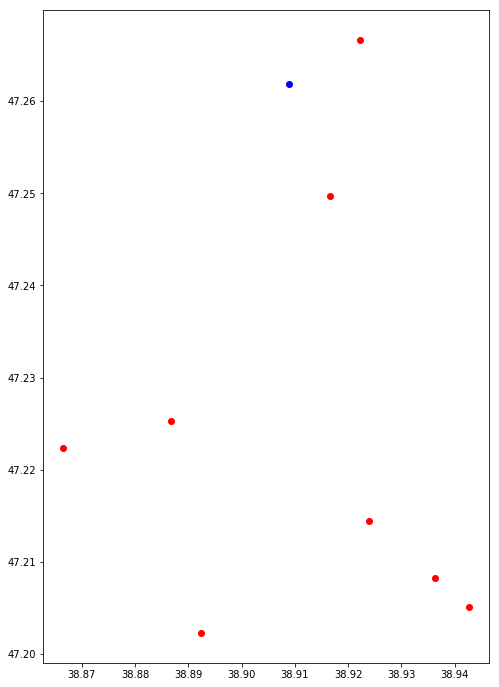

In [13]:
fig = plt.gcf()
fig.set_size_inches(8, 12)    #установка большого размера полотна
Lon_Lat = []

# for key in list_adj:
#     for nd in list_adj[key]:
#         plt.plot([nodes[key][1],nodes[nd][1]], [nodes[key][0],nodes[nd][0]], 'blue')

for h in hospitals:
    plt.plot(hospitals.get(h)[1], hospitals.get(h)[0], 'ro')
plt.plot(nodes.get(start)[1], nodes.get(start)[0],  'bo')

plt.show()

In [14]:
#алгоритм Дейкстры
from heapq import heappush, heappop 

def Dejicstra(a, b):
    
    len_sh_way = {nd: 1000000 for nd in nodes} # вершине соответствует длина пути до нее 
    len_sh_way.update({a: 0})
    
    shortest_way = {nd: [] for nd in nodes} #кратчайший путь от вершины a
    shortest_way.update({a: [a]})
    
    current_node = a
    
    nd_to_visit = []                 #ближайшие смежные
    deleted = []                     #удаленные 
    nd_to_visit.append(a)
    
    sort_len = []  #очередь с приорететом: вес вершины - номер вершины
    
    while(1):
        if current_node != b:   # если не конечная вершина
            
            sort_len = [len_sh_way.get(nd) for nd in nd_to_visit]  # делаем массив из весов оставшихся вершин
            sort_len.sort()            # сортируем его, чтобы найти с наименьшим весом
                     
            for key in nd_to_visit: # ищем  вершину с минимальным весом
                if len_sh_way.get(key) == sort_len[0]: 
                    current_node = key              # запоминаем ее
                    deleted.append(key)             # добавляем в список удаленных
                    break
            
            nd_to_vis = list(tuple(list_adj.get(current_node))) # получаем список вершин, с которыми смежна текущая
            
            for nd in nd_to_vis:           #добавляем их в список вершин для посещения
                nd_to_visit.append(nd)
            nd_to_visit = list(set(nd_to_visit)) # убираем повторения
                
            for nd in deleted:        # новые вершины могут быть смежны с вершинами, которые уже удалили
                if nd_to_visit.count(nd) > 0:
                    nd_to_visit.remove(nd)    
            
            for u in nd_to_visit:          #для всех остальных вершин    
                weight = math.sqrt((nodes.get(u)[1] + nodes.get(current_node)[1])**2 + (nodes.get(u)[0] + nodes.get(current_node)[0])**2)
                
                if len_sh_way.get(u) > len_sh_way.get(current_node) + weight: # если от нынешней вершины до неe ближе                
                
                    w = len_sh_way.get(current_node) + weight
                    len_sh_way.update({u: w}) # перезаписываем длину
                                   
                    mas = list(tuple(shortest_way.get(current_node)))
                    mas.append(u)
                    m = list(tuple(mas))
                    shortest_way.update({u: m}) # перезаписываем путь
                    
            if len(nd_to_visit) == 0:
                return shortest_way.get(b)
                break
        
        else: 
            break
        
    return (shortest_way.get(b))

In [15]:
#Алгоритм Левита
from collections import deque

def Levita(a, b):
    len_sh_way = {nd: 1000000 for nd in nodes} # вершине соответствует длина пути до нее 
    len_sh_way.update({a: 0})
    
    shortest_way = {nd: [] for nd in nodes} #кратчайший путь от вершины a
    shortest_way.update({a: [a]})
    
    nodes_already_calc = [] # M0
    common_queue = deque((a,))       # M1'
    rush_queue = deque()         # M1''
    
    nodes_not_calc = [nd for nd in nodes] # M2
    nodes_not_calc.remove(a)
    
    cur_node = a
    
    while(len(common_queue) > 0 or len(rush_queue) > 0):
        if len(rush_queue) > 0:
            current_node = rush_queue.popleft()
        else:
            cur_node = common_queue.popleft()
             
        adj = list_adj.get(cur_node)
        
        for nd in adj:
            w = math.sqrt((nodes.get(nd)[0] - nodes.get(cur_node)[0])**2 + (nodes.get(nd)[1] - nodes.get(cur_node)[1])**2)
           
            if nodes_not_calc.count(nd) > 0:
                common_queue.append(nd)
                nodes_not_calc.remove(nd)
                
                if len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                    
                    len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                    way = shortest_way.get(cur_node)[:]
                    way.append(nd)
                    shortest_way.update({nd: way})
                          
                
            elif common_queue.count(nd) > 0 or rush_queue.count(nd) > 0:
                if len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                    
                    len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                    way = shortest_way.get(cur_node)[:]
                    way.append(nd)
                    shortest_way.update({nd: way})
                    
            elif nodes_already_calc.count(nd) > 0 and len_sh_way.get(nd) > len_sh_way.get(cur_node) + w:
                
                rush_queue.append(nd)
                nodes_already_calc.remove(nd)
                
                len_sh_way.update({nd: len_sh_way.get(cur_node) + w})
                way = shortest_way.get(cur_node)[:]
                way.append(nd)
                shortest_way.update({nd: way})        
                          
        nodes_already_calc.append(cur_node)     
                          
    return(shortest_way.get(b))


In [17]:
#отрисовка в matplotlib для моих алгоритмов

def PlotResult(a, b, way):
    fig = plt.gcf()
    fig.set_size_inches(8, 12)    #установка большого размера полотна
    Lon_Lat = []

    #общая карта
#     for key in list_adj:
#         for nd in list_adj[key]:
#             plt.plot([nodes[key][1],nodes[nd][1]], [nodes[key][0],nodes[nd][0]], 'blue')

    #граничные узлы
    plt.plot(nodes.get(a)[1], nodes.get(a)[0], 'ro')
    plt.plot(nodes.get(b)[1], nodes.get(b)[0], 'ro')

    #путь
    for nd in way:                 #проход по узлам найденного пути
        Lon_Lat.append([nodes.get(nd)[1], nodes.get(nd)[0]])
    Lon_Lat = np.array(Lon_Lat)   
    plt.plot(Lon_Lat[::, 0], Lon_Lat[::, 1], 'red')
    Lon_Lat = []


    plt.show()
    

In [26]:
#вызов моего дейкстры и Левита
import time

start_time = time.time()
way = Dejicstra(start, target[3])
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
way = Levita(start, target[3])
print("--- %s seconds ---" % (time.time() - start_time))

#в связи с плачевным временем работы моего алгоритма Дейкстры, в дальнейшем он использоваться не будет

--- 112.773857117 seconds ---
--- 13.2305500507 seconds ---


In [18]:
#граф в networkx
import networkx as nx

GG = nx.Graph()

# добавляем узлы в граф
for key in nodes:
    GG.add_node(str(key),pos=tuple(nodes.get(key)))

# добавляем ребра в граф
for nd in list_adj:
    for nod in list_adj.get(nd):
        w = math.sqrt((nodes.get(nd)[1] + nodes.get(nod)[1])**2 + (nodes.get(nd)[0] + nodes.get(nod)[0])**2)
        GG.add_edge(str(nd),str(nod),weight=w)
                

In [19]:
#словарь узлов для networkx
nodesi = {str(key): [nodes.get(key)[1], nodes.get(key)[0]] for key in nodes}

In [20]:
#отрисовка графа в networkx
def DrawGraph():
    nx.draw_networkx(GG, pos=nodesi, node_size = 0.1, width = 0.2, with_labels = False)
    plt.axis('on')
    plt.show()

In [30]:
#отрисовка в networkx кратчайшего пути

def DrawSaveShortestWay(GG, way, start, end):
    nx.draw_networkx(GG, pos=nodesi, node_size = 0, width = 0.2, with_labels = False, node_color='black', edge_color='black')
    h = GG.subgraph(way)
    nx.draw_networkx_nodes(h,pos=nodesi, node_color='red', node_size = 2) 
    nx.draw_networkx_edges(h,pos=nodesi, edge_color='red', width = 2)
    fig = plt.gcf()
    fig.set_size_inches(8, 12)
    #plt.show()
    filename = "ShortestWay__" + str(start) + "__" + str(end) + ".png"
    plt.savefig(filename, dpi = 100)
    fig.clear()


In [23]:
#эвристические функции для А стар
import math

def ManhattanDist(start, finish):
    return abs(nodes.get(float(start))[0]-nodes.get(float(finish))[0])/2 + abs(nodes.get(float(start))[1]-nodes.get(float(finish))[1])/2

def ChebDist(start, finish):
    return max(abs(nodes.get(float(start))[0]-nodes.get(float(finish))[0]), abs(nodes.get(float(start))[1]-nodes.get(float(finish))[1]))

def EuklidDist(start, finish):
    return math.sqrt((nodes.get(float(start))[0]-nodes.get(float(finish))[0])**2 + (nodes.get(float(start))[1]-nodes.get(float(finish))[1])**2)

In [52]:
#время выполнения из networkx Дейкстры и А стар
import time

def timeDejicstra(start, target):
    start_time = time.time()
    Dejicstra = nx.dijkstra_path(GG, str(start), str(target))
    return time.time() - start_time
    #print("--- %s seconds ---" % (time.time() - start_time))
    #drawShortestWay(GG, Dejicstra,start, target[1])

def timeAstarManh(start, target):
    start_time = time.time()
    Astar_Manh = nx.astar_path(GG, str(start), str(target), ManhattanDist)
    return time.time() - start_time
    #print("--- %s seconds ---" % (time.time() - start_time))
    #drawShortestWay(GG, Astar_Manh) 

def timeAstarCheb(start, target):
    start_time = time.time()
    Astar_Cheb = nx.astar_path(GG, str(start), str(target), ChebDist)
    return time.time() - start_time
    #print("--- %s seconds ---" % (time.time() - start_time))
    #drawShortestWay(GG, Astar_Cheb) 

def timeAstarEukl(start, target):
    start_time = time.time()
    Astar_Eukl = nx.astar_path(GG, str(start), str(target), EuklidDist) 
    return time.time() - start_time
    #print("--- %s seconds ---" % (time.time() - start_time))
    #drawShortestWay(GG, Astar_Eukl) 


In [32]:
#запись получисшихся маршрутов в файл

def WriteCsvFile(start, target, way):
    filename =  "ShortestWay__" + str(start) + "__" + str(target) + ".csv"
    with open(filename, "a") as file:
        writer = csv.writer(file)
        writer.writerow(way)
    

In [33]:
#маршруты до больниц с записью в файл и сохранением картинок

for t in target:
    Dejicstra = nx.dijkstra_path(GG, str(start), str(t))
    DrawSaveShortestWay(GG, Dejicstra, str(start), str(t))
    WriteCsvFile(str(start), str(t), Dejicstra)

In [85]:
#выбираем 100 точек
random = nodes.items()[1:1501:15]

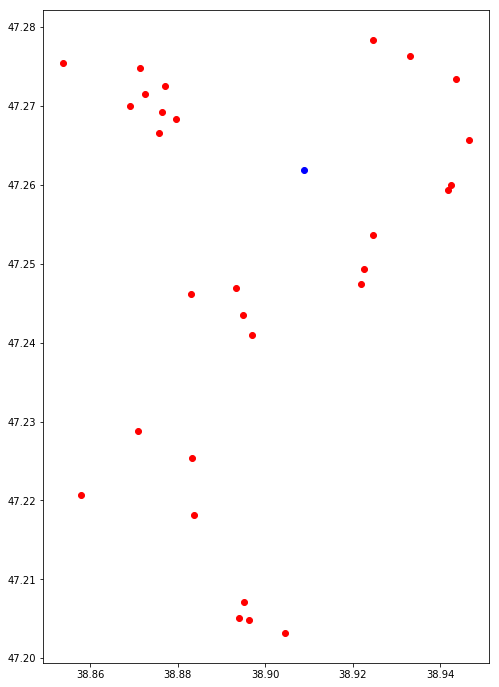

In [86]:
fig = plt.gcf()
fig.set_size_inches(8, 12)    #установка большого размера полотна
Lon_Lat = []

for r in random[1:30]:
    plt.plot(nodes.get(r[0])[1], nodes.get(r[0])[0], 'ro')
plt.plot(nodes.get(start)[1], nodes.get(start)[0],  'bo')

plt.show()

In [78]:
#запись статистики для 100 точек
filename =  "Statistics__100__points" + ".csv"

#шапочка файла
fieldnames = ['idNode', 'Dejicstra', 'Levit', 'AstarEuklid','AstarManh', 'AstarCheb']

#запись шапочки
with open(filename, "w") as file:
    writer = csv.DictWriter(file, delimiter=',', fieldnames=fieldnames)
    writer.writeheader()
    
def csv_writer(path, fieldnames, data):
    with open(path, "a") as out_file:
        writer = csv.DictWriter(out_file, delimiter=',', fieldnames=fieldnames)
        for row in data:
            writer.writerow(row)

for nd in random:
    cur_node = nd[0]
    line = []
    line_dict = []
    dejicstr = timeDejicstra(start, cur_node)
    aStEukl = timeAstarEukl(start, cur_node)
    aStManh = timeAstarManh(start, cur_node)
    aStCheb = timeAstarCheb(start, cur_node)
    
    start_time = time.time()
    way = Levita(start, cur_node)
    levit = time.time() - start_time
    
    #чтобы записалось с шапочкой нормально
    line = [cur_node, dejicstr, levit, aStEukl, aStManh, aStCheb]
    inner_dict = dict(zip(fieldnames, line))
    line_dict.append(inner_dict)
    csv_writer(filename, fieldnames, line_dict)
